# Mod 3 Final Project

## Student Info

- Name: Alex Beat
- Cohort: 100719 pt 
- Instructor: James Irving


## Instructions:

- Open and read the project assignment and guidelines in `MOD_PROJECT_README.ipynb`
- Review the hypothesis testing workflow found in this repo's `README.md` and at the bottom of the `MOD_PROJECT_README.ipynb`
- 3 functions from study group/learn.co lessons have been provided inside `functions.py`
    - `Cohen_d`, `find_outliers_IQR`,`find_outliers_Z`

<img src="https://raw.githubusercontent.com/jirvingphd/dsc-mod-3-project-online-ds-ft-100719/master/Northwind_ERD_updated.png">

# PROJECT

In [1]:
!pip install -U fsds_100719
from fsds_100719.imports import *

import pandas as pd


fsds_1007219  v0.7.4 loaded.  Read the docs: https://fsds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds_100719,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


['[i] Pandas .iplot() method activated.']


In [2]:

import scipy.stats as stats
import numpy as np

def Cohen_d(group1, group2, correction = False):
    """Compute Cohen's d
    d = (group1.mean()-group2.mean())/pool_variance.
    pooled_variance= (n1 * var1 + n2 * var2) / (n1 + n2)

    Args:
        group1 (Series or NumPy array): group 1 for calculating d
        group2 (Series or NumPy array): group 2 for calculating d
        correction (bool): Apply equation correction if N<50. Default is False. 
            - Url with small ncorrection equation: 
                - https://www.statisticshowto.datasciencecentral.com/cohens-d/ 
    Returns:
        d (float): calculated d value
         
    INTERPRETATION OF COHEN's D: 
    > Small effect = 0.2
    > Medium Effect = 0.5
    > Large Effect = 0.8
    
    """
    import scipy.stats as stats
    import scipy   
    import numpy as np
    N = len(group1)+len(group2)
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    ## Apply correction if needed
    if (N < 50) & (correction==True):
        d=d * ((N-3)/(N-2.25))*np.sqrt((N-2)/N)
    return d


#Your code here
def find_outliers_Z(data):
    """Use scipy to calculate absolute Z-scores 
    and return boolean series where True indicates it is an outlier.

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    """
    import pandas as pd
    import numpy as np
    import scipy.stats as stats
    import pandas as pd
    import numpy as np
    ## Calculate z-scores
    zs = stats.zscore(data)
    
    ## Find z-scores >3 awayfrom mean
    idx_outs = np.abs(zs)>3
    
    ## If input was a series, make idx_outs index match
    if isinstance(data,pd.Series):
        return pd.Series(idx_outs,index=data.index)
    else:
        return pd.Series(idx_outs)
    
    
    
def find_outliers_IQR(data):
    """Use Tukey's Method of outlier removal AKA InterQuartile-Range Rule
    and return boolean series where True indicates it is an outlier.
    - Calculates the range between the 75% and 25% quartiles
    - Outliers fall outside upper and lower limits, using a treshold of  1.5*IQR the 75% and 25% quartiles.

    IQR Range Calculation:    
        res = df.describe()
        IQR = res['75%'] -  res['25%']
        lower_limit = res['25%'] - 1.5*IQR
        upper_limit = res['75%'] + 1.5*IQR

    Args:
        data (Series,or ndarray): data to test for outliers.

    Returns:
        [boolean Series]: A True/False for each row use to slice outliers.
        
    EXAMPLE USE: 
    >> idx_outs = find_outliers_df(df['AdjustedCompensation'])
    >> good_data = df[~idx_outs].copy()
    
    """
    df_b=data
    res= df_b.describe()

    IQR = res['75%'] -  res['25%']
    lower_limit = res['25%'] - 1.5*IQR
    upper_limit = res['75%'] + 1.5*IQR

    idx_outs = (df_b>upper_limit) | (df_b<lower_limit)

    return idx_outs


def prep_data_for_tukeys(data):
    """Accepts a dictionary with group names as the keys 
    and pandas series as the values. 
    
    Returns a dataframe ready for tukeys test:
    - with a 'data' column and a 'group' column for sms.stats.multicomp.pairwise_tukeyhsd 
    
    Example Use:
    df_tukey = prep_data_for_tukeys(grp_data)
    tukey = sms.stats.multicomp.pairwise_tukeyhsd(df_tukey['data'], df_tukey['group'])
    tukey.summary()
    """
    import pandas as pd
    df_tukey = pd.DataFrame(columns=['data','group'])

    for k,v in  data.items():
        grp_df = v.rename('data').to_frame() 
        grp_df['group'] = k
        df_tukey=pd.concat([df_tukey,grp_df],axis=0)
    return df_tukey

In [3]:
import sqlite3
connect = sqlite3.connect('Northwind_small.sqlite')
cur = connect.cursor()

In [4]:
cur.execute("""SELECT name FROM sqlite_master WHERE type='table';""")
df_tables = pd.DataFrame(cur.fetchall(), columns=['Table'])
df_tables

,Table
0,Employee
1,Category
2,Customer
3,Shipper
4,Supplier
5,Order
6,Product
7,OrderDetail
8,CustomerCustomerDemo
9,CustomerDemographic


# Hypothesis 1

## Question

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

## Null and Alternative Hypothesis

- $H_0$: Customers bought the same quantity of both discounted and non-discounted products. 

- $H_1$: Customers bought the same quantity of both discounted and non-discounted products.

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test

### split data into 2 groups

In [5]:
cur.execute("""SELECT * from OrderDetail""")
col_names=[x[0] for x in cur.description]
col_names

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']

In [6]:
h1df = pd.DataFrame(cur.fetchall(), columns=col_names)
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.00,12,0.00
1,10248/42,10248,42,9.80,10,0.00
2,10248/72,10248,72,34.80,5,0.00
3,10249/14,10249,14,18.60,9,0.00
4,10249/51,10249,51,42.40,40,0.00
...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03
2151,11077/66,11077,66,17.00,1,0.00
2152,11077/73,11077,73,15.00,2,0.01
2153,11077/75,11077,75,7.75,4,0.00


In [7]:
## Create 'discounted' column for groupby 
h1df['discounted'] = h1df['Discount']>0
h1df['discounted'] = h1df['discounted'].map({True:'Discounted',False:'Full Price'})
h1df

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.00,12,0.00,Full Price
1,10248/42,10248,42,9.80,10,0.00,Full Price
2,10248/72,10248,72,34.80,5,0.00,Full Price
3,10249/14,10249,14,18.60,9,0.00,Full Price
4,10249/51,10249,51,42.40,40,0.00,Full Price
...,...,...,...,...,...,...,...
2150,11077/64,11077,64,33.25,2,0.03,Discounted
2151,11077/66,11077,66,17.00,1,0.00,Full Price
2152,11077/73,11077,73,15.00,2,0.01,Discounted
2153,11077/75,11077,75,7.75,4,0.00,Full Price


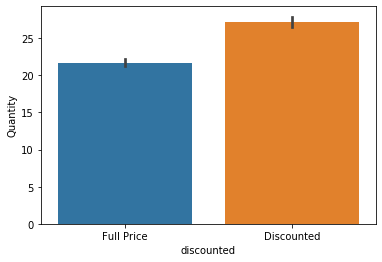

In [9]:
sns.barplot(data=h1df, x='discounted',y='Quantity',ci=68,)

### put data into dict

In [13]:
h1dict = {}
for name in h1df['discounted'].unique():
    h1dict[name] = h1df.groupby('discounted').get_group(name)['Quantity']
    
h1dict

{'Full Price': 0       12
 1       10
 2        5
 3        9
 4       40
         ..
 2147     2
 2148     2
 2151     1
 2153     4
 2154     2
 Name: Quantity, Length: 1317, dtype: int64, 'Discounted': 6       35
 7       15
 8        6
 9       15
 11      40
         ..
 2144     2
 2146     3
 2149     2
 2150     2
 2152     2
 Name: Quantity, Length: 838, dtype: int64}

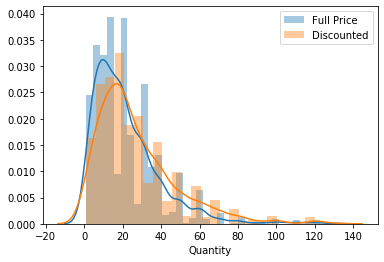

In [15]:
[sns.distplot(v,label=k) for k,v in h1dict.items()]
plt.legend()

## STEP 2: Do we meet the assumptions of the chosen test?

Independent t-test (2-sample)

- No significant outliers
- Normality
- Equal Variance

### 0. Check for & Remove Outliers

[Text(0, 0.5, 'Density'),
 Text(0.5, 1.0, 'Quantity for Full Price vs Discounted Products')]

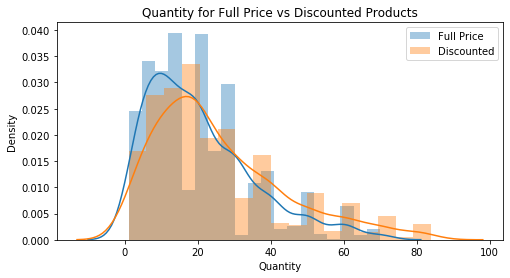

In [19]:
##Outlier Removal
fig,ax=plt.subplots(figsize=(8,4))
for name,values in h1dict.items():
    sns.distplot(values,label=name, ax=ax)
    
    
ax.legend()
ax.set(title='Quantity for Full Price vs Discounted Products', ylabel='Density')

In [16]:
for name,values in h1dict.items():
    idx_outs = find_outliers_Z(values)
    print(f"Found {idx_outs.sum()} outliers using Z-score method for {name}.")
    h1dict[name] = values[~idx_outs]
    

Found 20 outliers using Z-score method for Full Price.
Found 15 outliers using Z-score method for Discounted.


### 1. Test Assumption of Normality

In [20]:
import scipy.stats as stats

In [21]:
for key,values in h1dict.items():
    stat,p = stats.normaltest(values)
    print(f"Group {key} Normaltest p-value={round(p,4)}")
    sig = 'is NOT' if p<.05 else 'IS'

    print(f"\t-The data {sig} normal.")

Group Full Price Normaltest p-value=0.0
	-The data is NOT normal.
Group Discounted Normaltest p-value=0.0
	-The data is NOT normal.


### 1B. We don't have normal data:

But group sizes (n) are bigger than required 15 for each group so we can safely ignore normality assumption. <br>
So we move on to equal variance assumption.

In [22]:
len(h1dict['Full Price']), len(h1dict['Discounted'])

(1297, 823)

In [25]:
data = []
for key,vals in h1dict.items():
    data.append(vals)
data[0]

0       12
1       10
2        5
3        9
4       40
        ..
2147     2
2148     2
2151     1
2153     4
2154     2
Name: Quantity, Length: 1297, dtype: int64

### 2. Test for Equal Variance

In [27]:
stats.levene(data[0],data[1])

LeveneResult(statistic=19.187113832590878, pvalue=1.2429073348187694e-05)

In [26]:
stat,p = stats.levene(*data)
print(f"Levene's Test for Equal Variance p-value={round(p,4)}")
sig = 'do NOT' if p<.05 else 'DO'

print(f"\t-The groups {sig} have equal variance.")

Levene's Test for Equal Variance p-value=0.0
	-The groups do NOT have equal variance.


### Failed the assumption of equal variance:

Use a Welch's T-Test. 
 - for scipy, add equal_var=False to ttest_ind

## STEP 3: Interpret Result & Post-Hoc Tests

### Perform hypothesis test from summary table above to get your p-value.

- If p value is < $\alpha$:

    - Reject the null hypothesis.
    - Calculate effect size (e.g. Cohen's $d$)
- If p<.05 AND you have multiple groups (i.e. ANOVA)

    - Must run a pairwise Tukey's test to know which groups were significantly different.
    - Tukey pairwise comparison test
    - statsmodels.stats.multicomp.pairwise_tukeyhsd
- Report statistical power (optional)

In [35]:
stat,h1p = stats.ttest_ind(h1dict['Full Price'], h1dict['Discounted'], equal_var=False)
print(f"Welch's t-test p value={round(p,4)}")

sig = 'is rejected' if h1p<.05 else 'is accepted'

print(f"\t- Null Hypothesis {sig}.")

Welch's t-test p value=0.0
	- Null Hypothesis is rejected.


### Calculate effect size (e.g. Cohen's  𝑑 )

In [40]:
effectsize = Cohen_d(h1dict['Full Price'],h1dict['Discounted'])
effectsize

-0.32001140965727837

# --Question

0.3 effect size is small. What does this tell us?

### Report statistical power (optional)

statsmodels.stats.power:
TTestIndPower , TTestPower

In [37]:
from statsmodels.stats.power import TTestIndPower, TTestPower
power_analysis = TTestIndPower()

In [38]:
len(h1dict['Full Price']+h1dict['Discounted'])

2120

In [43]:
# show the power to see how well we can reject null.
power_analysis.solve_power(effect_size=effectsize, nobs1=2120, alpha=h1p)

0.9998181894007312

In [44]:
# power is .99 so yeah we have a solid bet of rejecting null hypothesis and not getting any type 1 errors.

## What levels of discount?

### If p<.05 AND you have multiple groups (i.e. ANOVA)

- Must run a pairwise Tukey's test to know which groups were significantly different.
- Tukey pairwise comparison test
- statsmodels.stats.multicomp.pairwise_tukeyhsd

> Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount? 

### Make dict into dataframes for tukeys

In [46]:
def prepare_for_tukeys(group):
    df_tukey= pd.DataFrame()
    for k,v in h1dict.items():
        df_grp = pd.DataFrame(v)
        df_grp['Group']=k
        df_tukey = pd.concat([df_tukey,df_grp],axis=0)

    return df_tukey

In [47]:
df_tukey = prepare_for_tukeys(h1dict)
df_tukey

,Quantity,Group
0,12,Full Price
1,10,Full Price
2,5,Full Price
3,9,Full Price
4,40,Full Price
...,...,...
2144,2,Discounted
2146,3,Discounted
2149,2,Discounted
2150,2,Discounted


In [48]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukeys = pairwise_tukeyhsd(df_tukey['Quantity'],df_tukey['Group'])
tukeys.summary()

TypeError: zip argument #4 must support iteration

# Hypothesis 2

## Question

> Does discount amount have a statistically significant effect on the total spent ($) on a product in an order? If so, at what level(s) of discount?

## Null and Alternative Hypothesis

- $H_0$: Customers bought the same quantity of both discounted and non-discounted products. 

- $H_1$: Customers bought the same quantity of both discounted and non-discounted products.

## STEP 1: Determine the category/type of test based on your data

Type of data: numeric <br>
    How many groups compared: Two different groups if comparing discount or full price.
        - So we use 2 sample t-test